### Task 95: Graph interest rate from providing CPT liquidity
* Graph the interest earned in the base balance of both assets in a CPT liquidity pool. The graph should show the following information

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.cpt import Liquidity
from python.dev.token import RebaseToken
from python.dev.token import Token
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import TokenDeltaModel

In [2]:
N_TOKENS = 2

### Part A: Simulation Run
* Initialize Rebasing/NonRebasing Tokens

In [3]:
APY = 0.1
TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TOKEN = N_TOKENS * [None]
ADDR = N_TOKENS * [None]
deposit = 10000 

TOKEN[0] = RebaseToken(TYPE_DEPOSIT_TOKEN)
ADDR[0] = TOKEN[0].mint(deposit, APY)

TOKEN[1] = RebaseToken(TYPE_DEPOSIT_TOKEN)
ADDR[1] = TOKEN[1].mint(deposit, APY)
    
x = TOKEN[0].get_balance_deposits()
y = TOKEN[1].get_balance_deposits()

# Initialize Liquidity Pool
liq = Liquidity(x,y)


* Simulate Deposits

In [4]:
percent = 0.05
N = 250
prices_yx = N * [0]
prices_xy = N * [0]

for k in range(N):

    token_delta = TokenDeltaModel(1,100).apply() 
    time_delta = TimeDeltaModel().apply() 
    TOKEN[0].add_event(Deposit(APY, token_delta, time_delta, ADDR[0]))

    token_delta = TokenDeltaModel(1,100).apply() 
    time_delta = TimeDeltaModel().apply() 
    TOKEN[1].add_event(Deposit(APY, token_delta, time_delta, ADDR[1]))        
        
    T1_yield = TOKEN[0].get_state_series(ADDR[0]).get_last_state().get_yield()
    T2_yield = TOKEN[1].get_state_series(ADDR[1]).get_last_state().get_yield()
    
    T1_delta = TOKEN[0].get_state_series(ADDR[0]).get_last_state().get_delta()
    T2_delta = TOKEN[1].get_state_series(ADDR[1]).get_last_state().get_delta()
        
    x = TOKEN[0].get_balance_deposits()
    y = TOKEN[1].get_balance_deposits()

    liq.delta_x(T1_delta+T1_yield)
    liq.delta_y(T2_delta+T2_yield)     
    L = liq.calc()
    prices_yx[k] = liq.get_swap_price(Liquidity.YX_PRICE)  
    prices_xy[k] = liq.get_swap_price(Liquidity.XY_PRICE)
    
    if (k % int(N/(100*percent)) == 0):
        out_str = '[SIM {}]'.format(k)
        for k in range(N_TOKENS):
            amt = TOKEN[k].get_balance_deposits()
            out_str = out_str+' T{}: {:.2f}'.format(k+1,amt)
            
        print(out_str) 
        

[SIM 0] T1: 10096.36 T2: 10178.01
[SIM 50] T1: 15545.48 T2: 15290.58
[SIM 100] T1: 21723.94 T2: 20937.29
[SIM 150] T1: 26721.92 T2: 25033.84
[SIM 200] T1: 32081.77 T2: 30361.86


### Part B: Plot Simulated Output

* Show the initial amounts of each asset deposited in liquidity

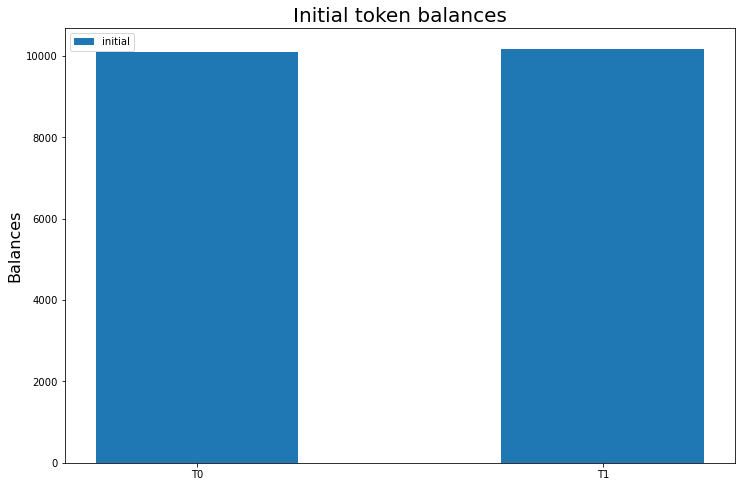

In [5]:
token_names = ['T'+str(k) for k in range(N_TOKENS)]
inital_balances = N_TOKENS*[0]

for k in range(N_TOKENS):
    inital_balances[k] = TOKEN[k].get_state_series(ADDR[k]).get_state(0).get_balance()

bar_width = 0.5
x = np.arange(len(TOKEN))

fig, (ax1) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 8))
ax1.set_title("Initial token balances", fontsize=20)
ax1.set_ylabel('Balances', fontsize=16)
b1 = ax1.bar(x, inital_balances, width=bar_width, label='initial')
ax1.set_xticks(x)
ax1.set_xticklabels(token_names)
plt.legend()
plt.show()


* Show the balances in liquidity of each asset at the end of a simulation run

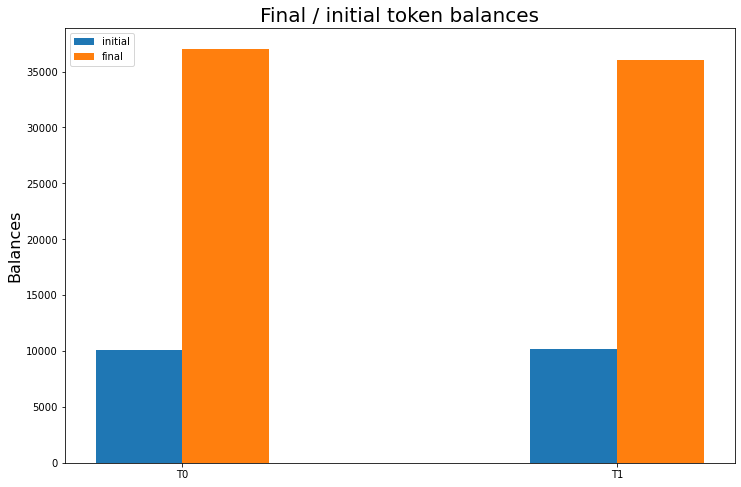

In [6]:
final_balances = [TOKEN[k].get_balance_deposits() for k in range(N_TOKENS)]
bar_width = 0.2

fig, (ax1) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 8))
ax1.set_title("Final / initial token balances", fontsize=20)
ax1.set_ylabel('Balances', fontsize=16)
b1 = ax1.bar(x, inital_balances, width=bar_width, label='initial')
b2 = ax1.bar(x + bar_width, final_balances, width=bar_width, label='final')
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(token_names)
plt.legend()
plt.show()


* Show the base balance delta of each asset in liquidity at the end of a simulation run

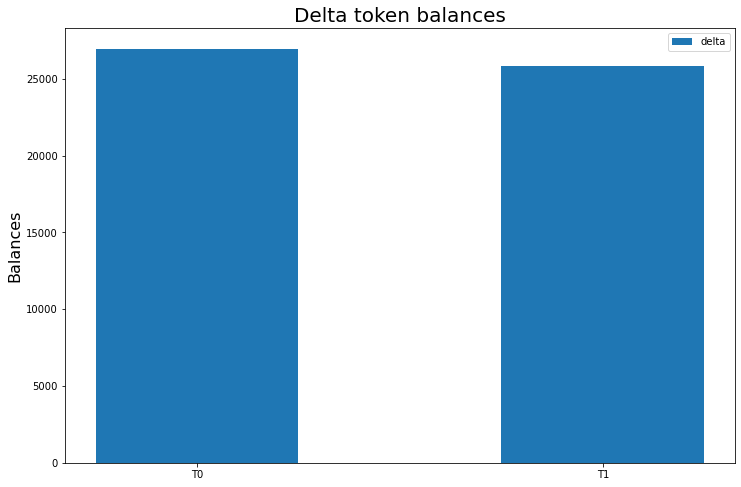

In [7]:
bar_width = 0.5
delta_balances = [final_balances[k]-inital_balances[k] for k in range(N_TOKENS)]

fig, (ax1) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 8))
ax1.set_title("Delta token balances", fontsize=20)
ax1.set_ylabel('Balances', fontsize=16)
b1 = ax1.bar(x, delta_balances, width=bar_width, label='delta')
ax1.set_xticks(x)
ax1.set_xticklabels(token_names)
plt.legend()
plt.show()


* Show the base balance delta as a percentage change at the end of a simulation run

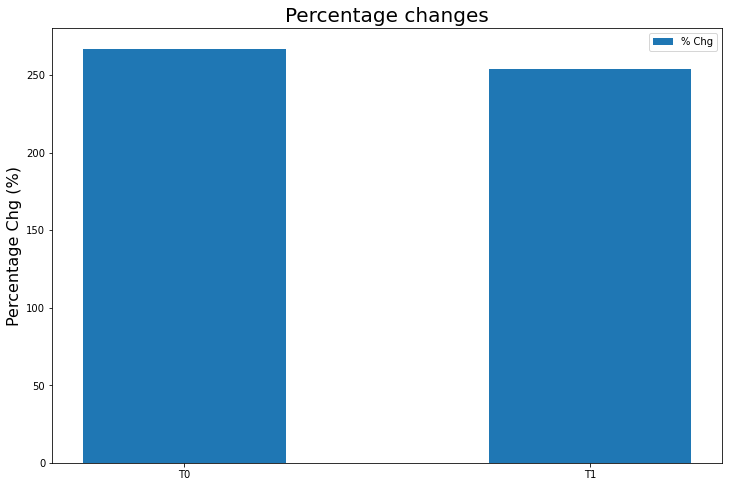

In [8]:
percentage_chg = [100*delta_balances[k]/inital_balances[k] for k in range(N_TOKENS)]
    
fig, (ax1) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 8))
ax1.set_title("Percentage changes", fontsize=20)
ax1.set_ylabel('Percentage Chg (%)', fontsize=16)
b1 = ax1.bar(x, percentage_chg, width=bar_width, label='% Chg')
ax1.set_xticks(x)
ax1.set_xticklabels(token_names)
plt.legend()
plt.show()    

* Show the price of each asset in the pool as priced against the other asset based on the liquidity at the end of a simulation run

    * T1 should be priced in T2 based on the reserves of T1 and T2 in that liquidity pool
    * T2 should be priced in T1 based on the reserves of T1 and T2 in that liquidity pool

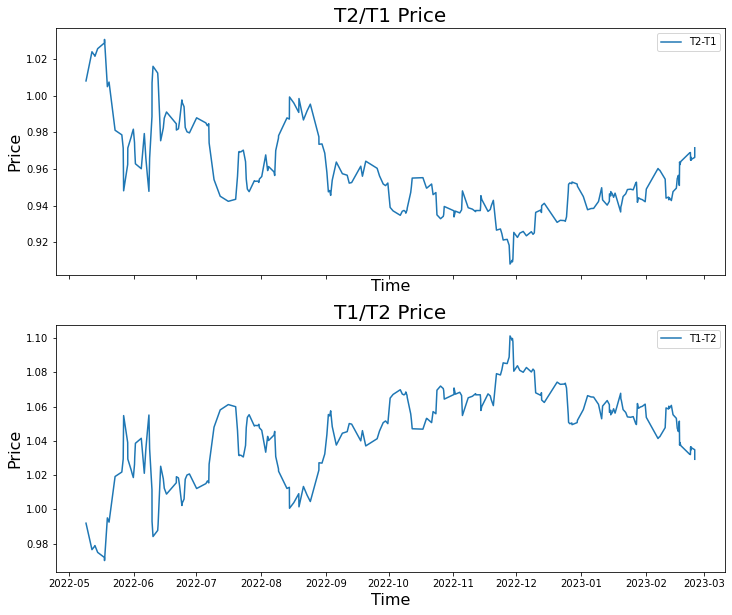

In [9]:
T1_states = TOKEN[0].get_state_series(ADDR[0])
tSamp = T1_states.get_tstamp()  

fig, (p1_ax, p2_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

p1_ax.plot(tSamp[1:], prices_yx, label='T2-T1') 
p1_ax.set_title("T2/T1 Price", fontsize=20)
p1_ax.set_ylabel("Price", fontsize=16)
p1_ax.set_xlabel('Time', fontsize=16)
p1_ax.legend()

p2_ax.plot(tSamp[1:], prices_xy, label='T1-T2') 
p2_ax.set_title("T1/T2 Price", fontsize=20)
p2_ax.set_ylabel("Price", fontsize=16)
p2_ax.set_xlabel('Time', fontsize=16)
p2_ax.legend()


* Show the interest earned as a percentage based on the price at the end of a simulation run compared to the price at initial listing

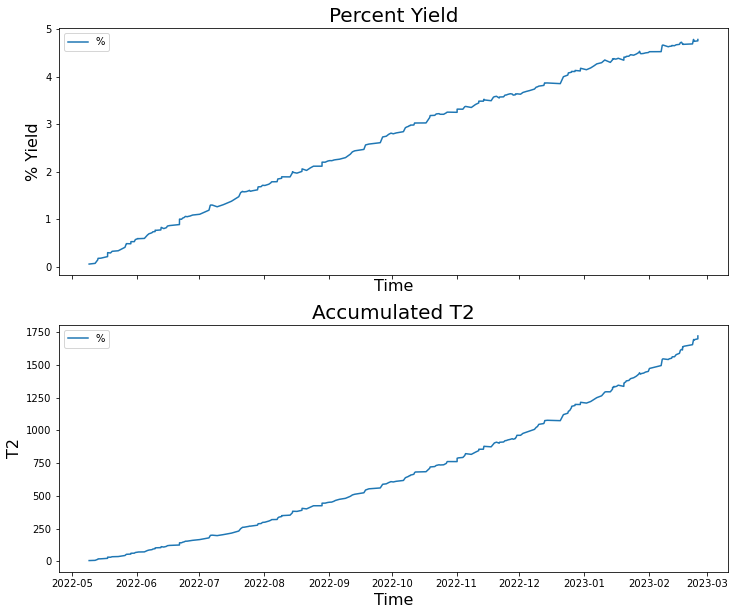

In [10]:
T1_balance = TOKEN[0].get_state_series(ADDR[0]).get_balance()
T1_principle = TOKEN[0].get_state_series(ADDR[0]).get_principle()
T1_yield = [T1_balance[k] - T1_principle[k] for k in range(N)]
tSamp = TOKEN[0].get_state_series(ADDR[0]).get_tstamp()  

percent_yield = [100*T1_yield[k]/T1_balance[k] for k in range(N)]
accumulated_t2 = [T1_yield[k]*prices_yx[k] for k in range(N)]

fig, (y_ax, t2_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

y_ax.plot(tSamp[1:], percent_yield, label='%') 
y_ax.set_title("Percent Yield", fontsize=20)
y_ax.set_ylabel("% Yield", fontsize=16)
y_ax.set_xlabel('Time', fontsize=16)
y_ax.legend()

t2_ax.plot(tSamp[1:], accumulated_t2, label='%') 
t2_ax.set_title("Accumulated T2", fontsize=20)
t2_ax.set_ylabel("T2", fontsize=16)
t2_ax.set_xlabel('Time', fontsize=16)
t2_ax.legend()


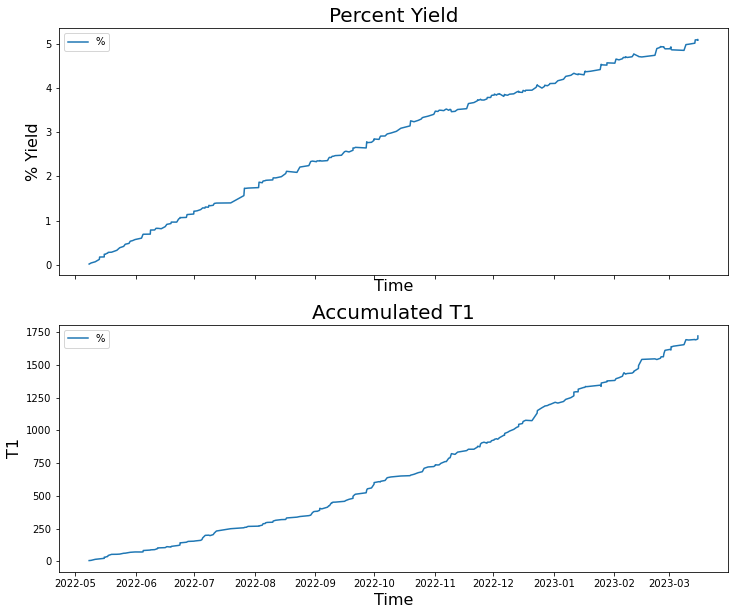

In [11]:
T2_balance = TOKEN[1].get_state_series(ADDR[1]).get_balance()
T2_principle = TOKEN[1].get_state_series(ADDR[1]).get_principle()
T2_yield = [T2_balance[k] - T2_principle[k] for k in range(N)]
tSamp = TOKEN[1].get_state_series(ADDR[1]).get_tstamp()  

percent_yield = [100*T2_yield[k]/T2_balance[k] for k in range(N)]
accumulated_t1 = [T2_yield[k]*prices_xy[k] for k in range(N)]

fig, (y_ax, t1_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

y_ax.plot(tSamp[1:], percent_yield, label='%') 
y_ax.set_title("Percent Yield", fontsize=20)
y_ax.set_ylabel("% Yield", fontsize=16)
y_ax.set_xlabel('Time', fontsize=16)
y_ax.legend()

t1_ax.plot(tSamp[1:], accumulated_t2, label='%') 
t1_ax.set_title("Accumulated T1", fontsize=20)
t1_ax.set_ylabel("T1", fontsize=16)
t1_ax.set_xlabel('Time', fontsize=16)
t1_ax.legend()